In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Money Flow Index (MFI) is a momentum indicator that uses both price and volume to measure buying and selling pressure. It works similarly to the RSI and ranges from 0 to 100.

When MFI > 80, the asset is considered overbought, suggesting a possible downward move.

When MFI < 20, the asset is considered oversold, indicating a potential upward reversal.

The MFI is calculated using the Typical Price and Volume over a given period, typically 14 periods.

C:\Users\Ferna\AppData\Local\Temp\ipykernel_27576\4063137725.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Average_Price,Money_Flow,Pos_Flow,Neg_Flow,MFI,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,,,,,
1993-02-18,24.085659,24.380444,23.756194,24.380444,378100,24.074099,9.102417e+06,0.000000e+00,9.102417e+06,65.783587,NaN,NaN,NaN
1993-02-19,24.172373,24.172373,24.050991,24.085671,34900,24.131912,8.422037e+05,8.422037e+05,0.000000e+00,66.049605,0.0,0.003600,0.000000
1993-02-22,24.259058,24.293739,24.172357,24.241718,513600,24.241718,1.245055e+07,1.245055e+07,0.000000e+00,66.260592,0.0,0.007199,0.000000
1993-02-23,24.241714,24.345756,24.120333,24.328416,373700,24.235934,9.056969e+06,0.000000e+00,9.056969e+06,59.479949,0.0,0.006479,0.000000
1993-02-24,24.553839,24.553839,24.259054,24.259054,26300,24.455577,6.431817e+05,6.431817e+05,0.000000e+00,54.454529,0.0,0.019438,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-24,606.780029,607.849976,603.409973,604.330017,67735300,606.013326,4.104849e+10,4.104849e+10,0.000000e+00,58.795805,0.0,24.192586,0.831327
2025-06-25,607.119995,608.609985,605.539978,607.909973,62114800,607.089986,3.770927e+10,3.770927e+10,0.000000e+00,59.032178,0.0,24.206701,0.831327
2025-06-26,611.869995,612.309998,608.369995,608.989990,78548400,610.849996,4.798129e+10,4.798129e+10,0.000000e+00,67.340703,0.0,24.403913,0.831327


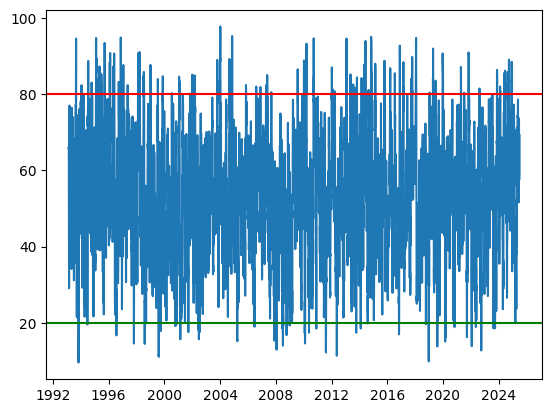

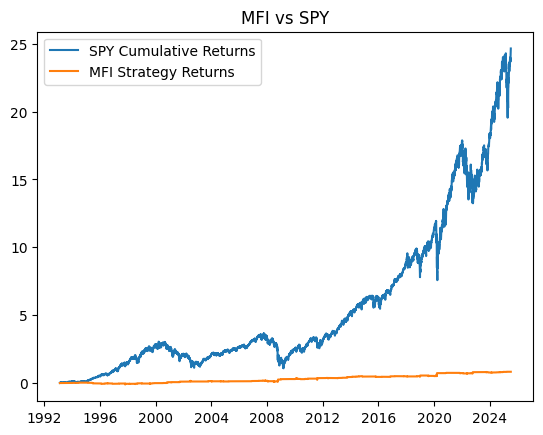

In [2]:
TICKER = 'SPY'
MFI_LENGHT = 14
OVERBOUGHT = 80 
OVERSOLD = 20
LOOKBACK = 10000

def get_data():
    df = yf.download(TICKER)
    df.columns = df.columns.get_level_values(0) # Get rid of multi-index

    return df.iloc[-LOOKBACK:,:] #Take a piece of the last "LOOKBACK" rows

def add_MFI(df, lenght = MFI_LENGHT):

    #Typical/Average Price
    df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_Flow'] = df['Volume'] * df['Average_Price']

    #initialize empty flows
    df['Pos_Flow'] = 0
    df['Neg_Flow'] = 0

    df['Pos_Flow'] = np.where(df['Average_Price'].diff() > 0, df['Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Average_Price'].diff() < 0, df['Money_Flow'], 0)

    mfr = df['Pos_Flow'].rolling(lenght).sum() / df['Neg_Flow'].rolling(lenght).sum()
    df['MFI'] = 100 - (100 / (1 + mfr))

    return df.dropna()

def add_strategy(df, overbought = OVERBOUGHT, oversold = OVERSOLD):

    df['Strategy'] = 0
    df['Strategy'] = np.where(df['MFI'] > overbought, -1, np.where(df['MFI'] < oversold, 1, 0))
    df['Strategy'] = df['Strategy'].shift(1)

    plt.plot(df['MFI'])
    plt.axhline(OVERBOUGHT, color = 'red')
    plt.axhline(OVERSOLD, color = 'green') 

    return df

def test_strategy(df, ticker = TICKER):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1

    plt.figure() # Make sure we can see our second plot
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{ticker} Cumulative Returns', 'MFI Strategy Returns'])
    plt.title(f'MFI vs {ticker}')

    return df

def main():
    df = get_data()
    df = add_MFI(df)
    df = add_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df